Задание

Цель: изучить применение методов оптимизации для решения задачи классификации
Описание задания:
В домашнем задании необходимо применить полученные знания в теории оптимизации и машинном обучении для реализации логистической регрессии.
Этапы работы:**

    Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.
    Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции. *Оформите в виде класса с методами.
    Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.
    Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).
    Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).
    Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.

Для лучшего понимания темы и упрощения реализации можете обратиться к статье.

Для получение зачета по этому домашнему заданию, минимально, должно быть реализовано обучение логистической регрессии и градиентный спуск.

Результат: получены навыки реализации методов оптимизации в задаче бинарной классификации. Пройденные методы оптимизации используются и в нейросетях.
Форма выполнения: ссылка на Jupyter Notebook, загруженный на GitHub; ссылка на Google Colab; файл с расширением .ipynb.
Инструменты: Jupyter Notebook/Google Colab; GitHub.
*Рекомендации к выполнению:
• Текст оформляйте в отдельной ячейке Jupyter Notebook/Google Colab в формате markdown.
• У графиков должен быть заголовок, подписи осей, легенда (опционально). Делайте графики бОльшего размера, чем стандартный вывод, чтобы увеличить читаемость.
• Убедитесь, что по ссылкам есть доступ на чтение/просмотр.
• Убедитесь, что все ячейки в работе выполнены и можно увидеть их вывод без повторного запуска.


### Решение. Класс с логистической регрессией.

In [1]:
import numpy as np
import pandas as pd


class MyLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-4, fit_intercept=True, optimizer='gradient_descent'):
        """
        Параметры:
        learning_rate: скорость обучения
        max_iter: максимальное количество итераций
        tol: критерий остановки (изменение функции потерь)
        fit_intercept: добавлять ли intercept (свободный член)
        optimizer: метод оптимизации ('gradient_descent' или 'rmsprop')
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.fit_intercept = fit_intercept
        self.weights = None
        self.loss_history = []
        self.optimizer = optimizer
        self.s = None # Скользящее среднее квадратов градиентов
        self.beta = 0.9 # параметр для RMSProp (коэффициент затухания)
        self.beta2 = 0.999 # параметр для второго момента (нецентрированная дисперсия)
        self.epsilon = 1e-15 # чсло близкое к 0, но не 0, чтобы не получить log(0)
        # Для адаптивных методов
        self.m = None  # Первый момент (среднее)
        self.v = None  # Второй момент (дисперсия)
        self.t = 0  # Счетчик итераций

    def _sigmoid(self, z):
        """Сигмоидная функция"""
        # Для избежания переполнения
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _add_intercept(self, X):
        """Добавляет столбец единиц для intercept"""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def _compute_loss(self, y, y_pred):
        """Вычисляет log loss"""
        y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def _gradient_descent_step(self, X, y, y_pred):
        """Шаг градиентного спуска"""
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        self.weights -= self.learning_rate * gradient
        return gradient

    def _rmsprop_step(self, X, y, y_pred):
        """Шаг RMSProp оптимизации"""
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)

        # Инициализируем s если это первая итерация
        if self.s is None:
            self.s = np.zeros_like(gradient)

        # Обновляем скользящее среднее квадратов градиентов
        self.s = self.beta * self.s + (1 - self.beta) * (gradient ** 2)

        # Обновляем веса с адаптивной скоростью обучения
        adaptive_lr = self.learning_rate / (np.sqrt(self.s) + self.epsilon)
        self.weights -= adaptive_lr * gradient

        return gradient

    def _nadam_step(self, X, y, y_pred):
        """
        Шаг Nadam оптимизации
        Сочетает Nesterov acceleration и Adam
        """
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)

        # Инициализация моментов при первой итерации
        if self.m is None:
            self.m = np.zeros_like(gradient)
            self.v = np.zeros_like(gradient)

        self.t += 1  # Увеличиваем счетчик итераций

        # Обновляем моменты
        self.m = self.beta * self.m + (1 - self.beta) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradient ** 2)

        # Корректируем моменты (bias correction)
        m_hat = self.m / (1 - self.beta ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # Nesterov momentum: смотрим немного вперед
        momentum_correction = self.beta * m_hat + (1 - self.beta) * gradient / (1 - self.beta ** self.t)

        # Обновляем веса
        self.weights -= self.learning_rate * momentum_correction / (np.sqrt(v_hat) + self.epsilon)

        return gradient

    def fit(self, X, y):
        """
        Обучение модели

        Параметры:
        X: признаки (n_samples, n_features)
        y: целевая переменная (n_samples,)
        """
        # Преобразуем в numpy массивы
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)

        # Инициализируем веса
        n_features = X.shape[1]
        self.weights = np.random.normal(0, 0.1, n_features)

        print(f"Используется оптимизатор: {self.optimizer}")

        # Градиентный спуск
        for i in range(self.max_iter):
            # Прямое распространение
            z = np.dot(X, self.weights)
            y_pred = self._sigmoid(z)

            # Выбираем метод оптимизации
            if self.optimizer == 'rmsprop':
                self._rmsprop_step(X, y, y_pred)
            elif self.optimizer == 'nadam':
                gradient = self._nadam_step(X, y, y_pred)
            else: # gradient_descent по умолчанию
                self._gradient_descent_step(X, y, y_pred)

            # Вычисляем loss и проверяем критерий остановки
            loss = self._compute_loss(y, y_pred)
            self.loss_history.append(loss)

            # Проверка сходимости
            if i > 0 and abs(self.loss_history[-2] - loss) < self.tol:
                print(f"Сходимость достигнута на итерации {i}")
                break

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict_proba(self, X):
        """Возвращает вероятности принадлежности к классу 1"""
        if isinstance(X, pd.DataFrame):
            X = X.values

        if self.fit_intercept:
            X = self._add_intercept(X)

        z = np.dot(X, self.weights)
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Возвращает предсказанные классы"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

    def score(self, X, y):
        """Вычисляет accuracy"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def get_params(self):
        """Возвращает параметры модели"""
        return {и
            'weights': self.weights,
            'loss_history': self.loss_history
        }

### Класс с обучением и сбором метрик.


Изучаем данные:
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 50 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  100 non-null    float64
 1   sepal width (cm)   100 non-null    float64
 2   petal length (cm)  100 non-null    float64
 3   petal width (cm)   100 non-null    float64
 4   target             100 non-null    int64  
 5   species            100 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 5.5+ KB
None
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
50                7.0               3.2                4.7               1.4   
51                6.4               3.2                4.5               1.5   
52                6.9               3.1                4.9               1.5   
53                5.5               2.3                4.0               1.3   
54                6.5           

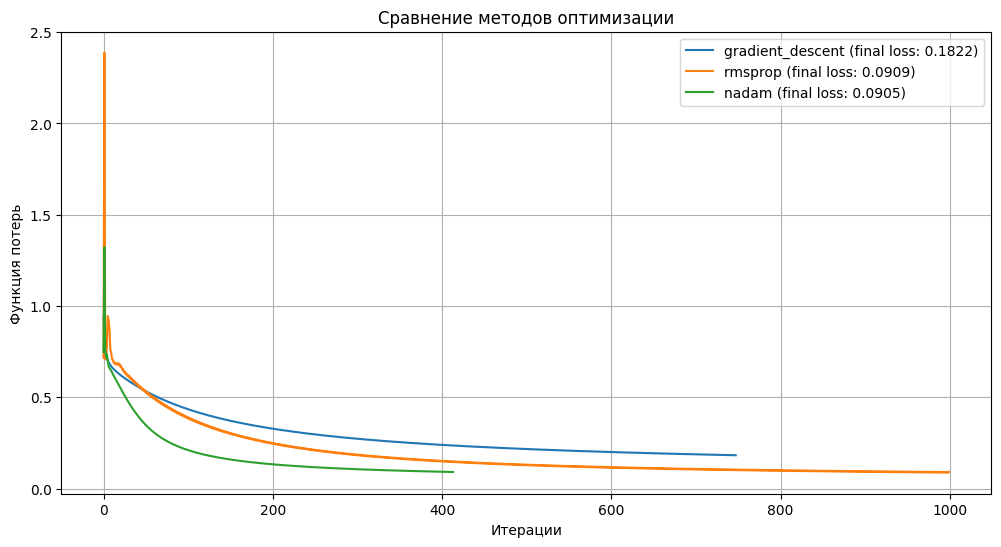

In [3]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
# from MyLogisticRegression import MyLogisticRegression
import matplotlib.pyplot as plt
import time

iris = load_iris()

# Для вывода всех столбцов
pd.set_option('display.max_columns', None)

# Считываем данные
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Добавляем целевую переменную (метки классов)
data['target'] = iris.target
data['species'] = iris.target_names[iris.target]

# Удаляем строки с species = 'setosa' и приводим к бинарным значениям 'target'
data = data[data['species'] != 'setosa']
data['target'] = data['target'] - 1

print('\nИзучаем данные:')
print(data.info())
print(data.head())
print(data.describe())
print('\nИзучаем уникальные итоговые значения:')
print(data['target'].unique())
print('\nПроверяем на нулевые значения:')
print(data[data['target'].isna()].head())

X = data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
print('\nВыделяем признаки:')
print(X.head())

Y = data['target']
print('\nВыделяем результат:')
print(Y.head())

# разделяем тестовые данные как 80/20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# Тестируем оба оптимизатора
optimizers = ['gradient_descent', 'rmsprop', 'nadam']
results = {}

for optimizer in optimizers:
    print(f"\n=== Тестируем {optimizer} ===")

    # Создаем модель с выбранным оптимизатором
    start_time = time.time()
    model = MyLogisticRegression(optimizer=optimizer)

    # Обучаем модель
    model.fit(X_train, Y_train)

    # Оцениваем точность
    model_score = model.score(X_test, Y_test)
    print(f'Точность {optimizer}: {model_score:.4f}')

    # Сохраняем результаты
    end_time = time.time()
    results[optimizer] = {
        'model': model,
        'score': model_score,
        'loss_history': model.loss_history,
        'time': end_time - start_time
    }

# Сравниваем графики потерь
plt.figure(figsize=(12, 6))

for optimizer in optimizers:
    loss_history = results[optimizer]['loss_history']
    plt.plot(loss_history, label=f'{optimizer} (final loss: {loss_history[-1]:.4f})')

plt.xlabel('Итерации')
plt.ylabel('Функция потерь')
plt.title('Сравнение методов оптимизации')
plt.legend()
plt.grid(True)
plt.savefig('optimization_comparison.png', dpi=300, bbox_inches='tight')
print("График сохранен как 'optimization_comparison.png'")

# Выводим итоговое сравнение
print("\n=== ИТОГОВОЕ СРАВНЕНИЕ ===")
for optimizer in optimizers:
    score = results[optimizer]['score']
    final_loss = results[optimizer]['loss_history'][-1]
    time_work = results[optimizer]['time']
    print(f"{optimizer}:\tТочность = {score:.4f},\tФинальные потери = {final_loss:.4f},\tВремя обучения = {time_work:.4f} секунд")


### Итоговые результаты для learning_rate = 0.1
- gradient_descent:	Точность = 0.9500,	Финальные потери = 0.1822,	Время обучения = 0.0178 секунд
- rmsprop:	        Точность = 0.9000,	Финальные потери = 0.0909,	Время обучения = 0.0273 секунд
- nadam:	        Точность = 0.9500,	Финальные потери = 0.0905,	Время обучения = 0.0141 секунд
### Итоговые результаты для learning_rate = 0.01
- gradient_descent:	Точность = 0.9500,	Финальные потери = 0.4300,	Время обучения = 0.0229 секунд
- rmsprop:	        Точность = 0.9500,	Финальные потери = 0.1111,	Время обучения = 0.0184 секунд
- nadam:	        Точность = 0.9500,	Финальные потери = 0.1363,	Время обучения = 0.0250 секунд
  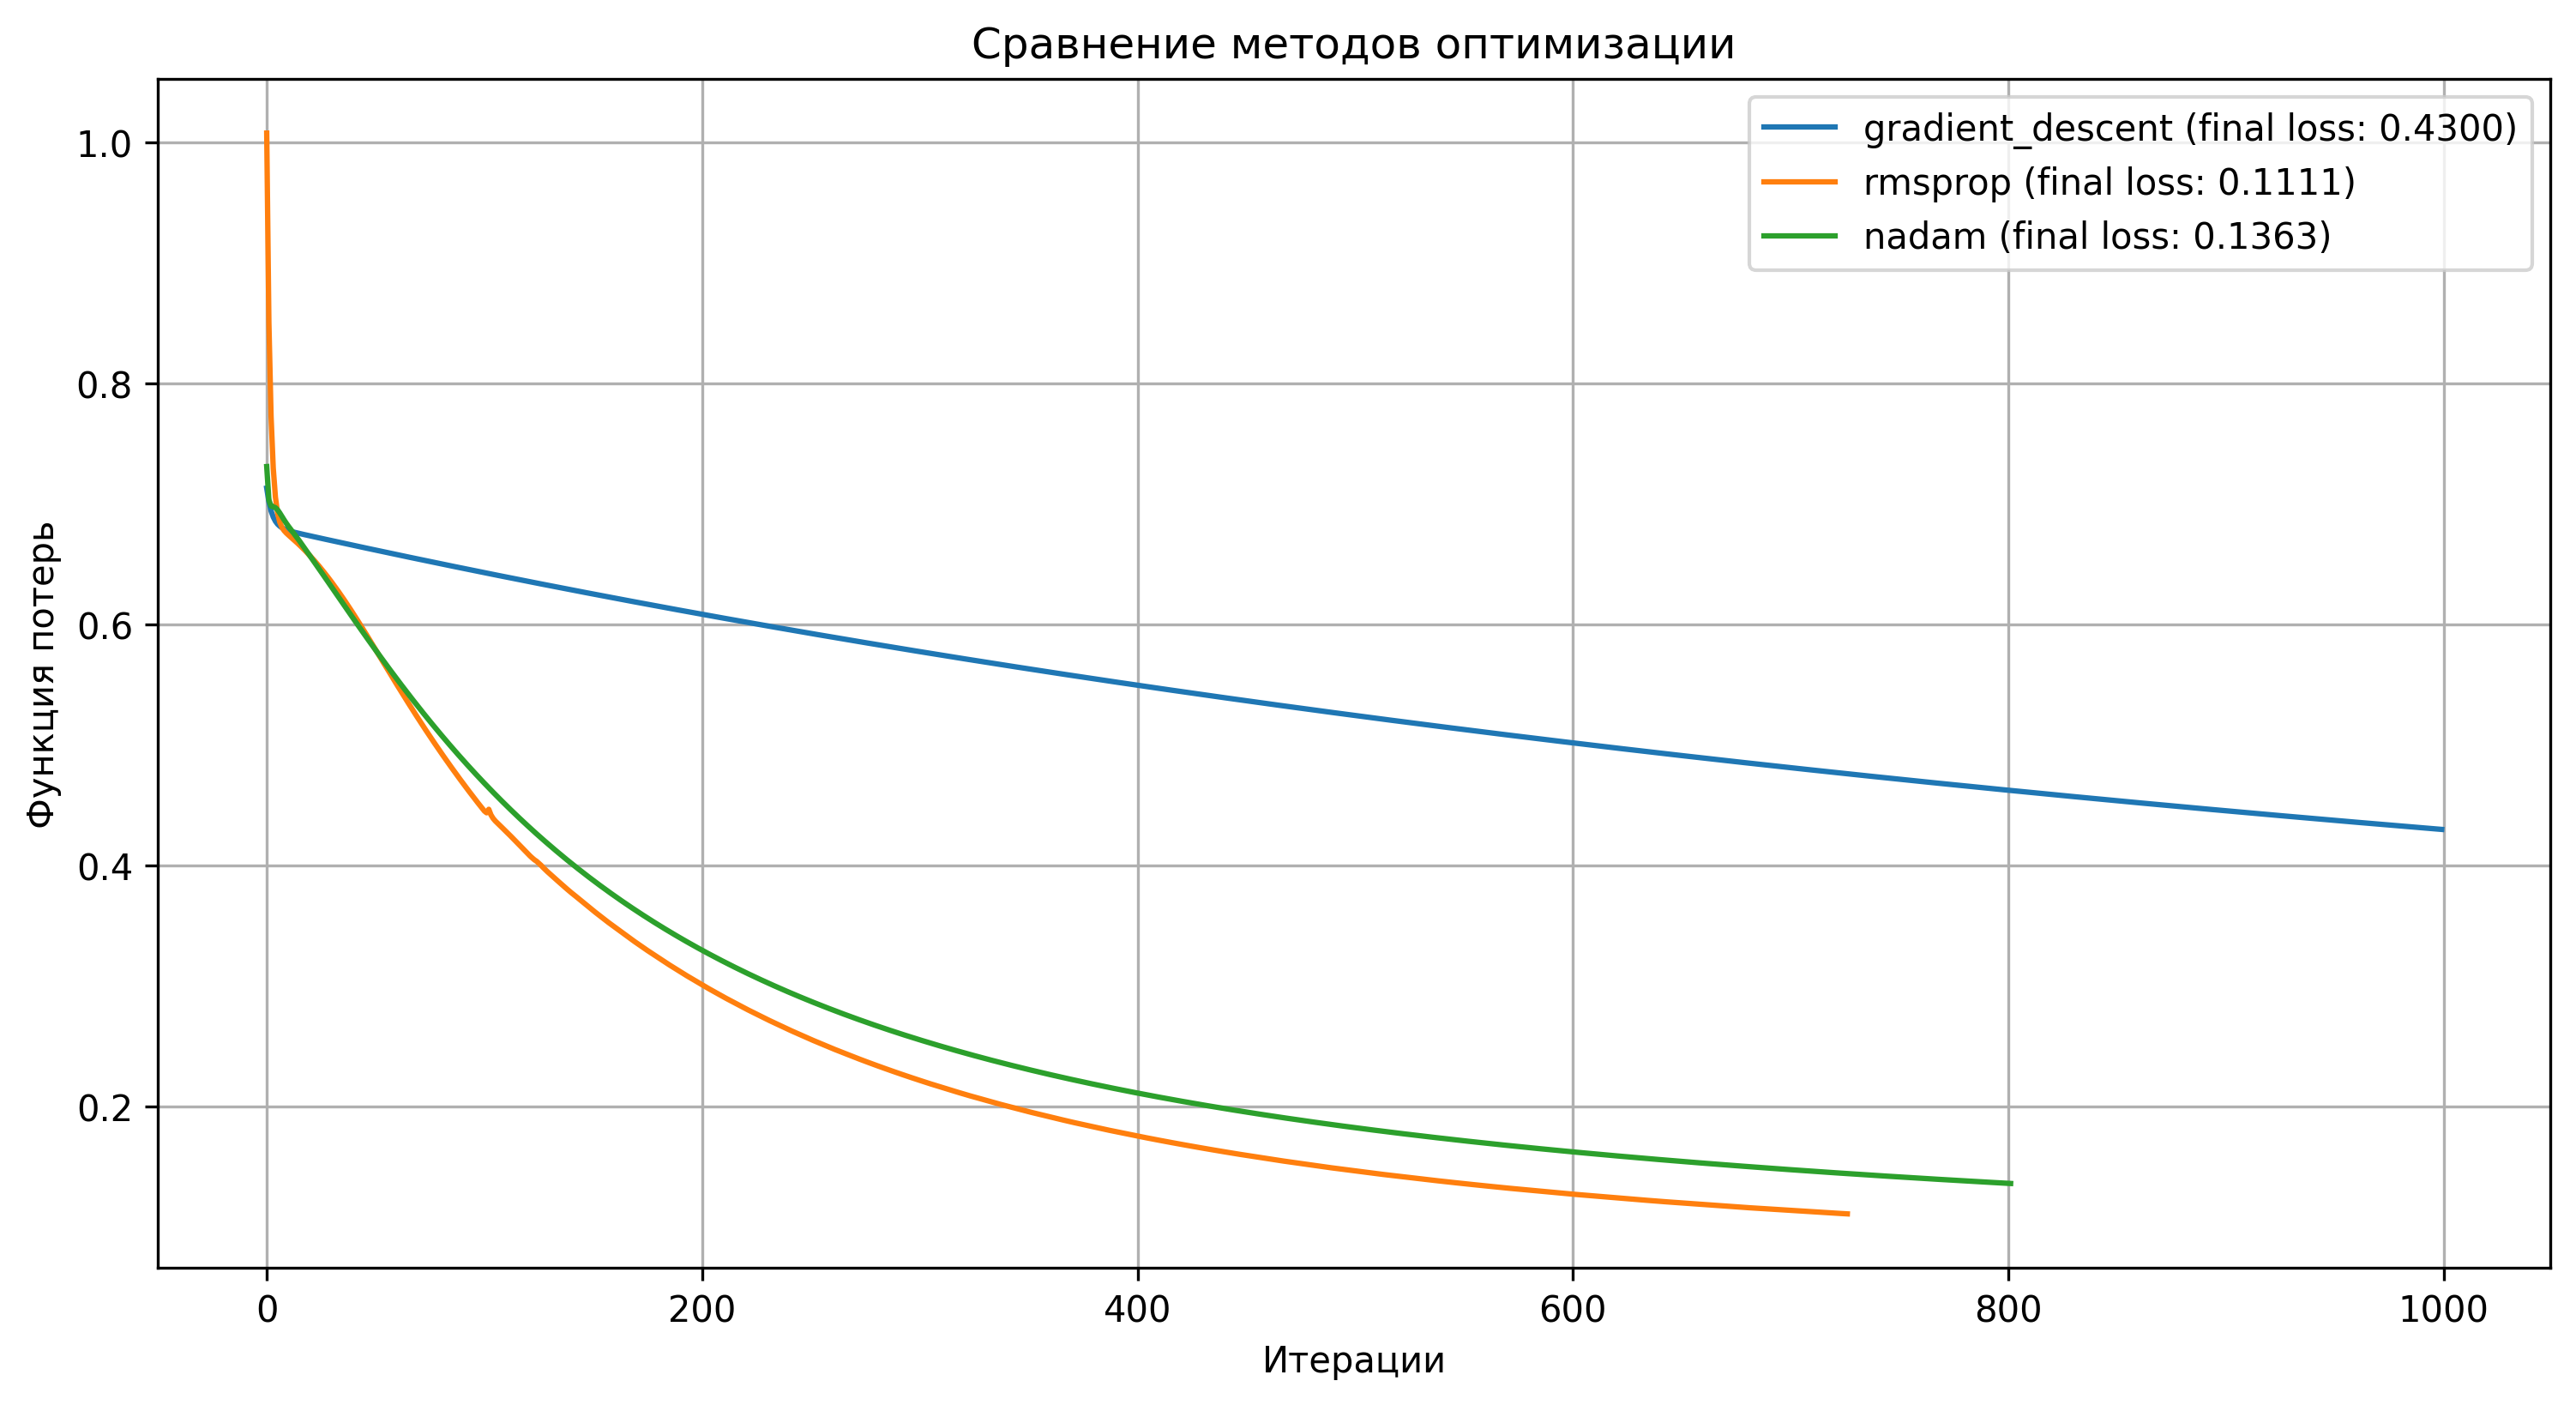

### Итоговые выводы:
- Метод градиентного спуска получил самые большие потери, но точность была не хуже остальных.
- Метод скользящего среднего получил чуть хуже точность при learning_rate = 0.1, но потери были ниже всех.
- Метод адаптивной оценки моментов, ускоренного по Нестерову, получился самым оптимальным и быстрым для learning_rate = 0.1. Но для learning_rate = 0.01 лучше использовать метод скользящего среднего.

Итог: идеального метода нет, так как все зависит от параметров и контекста. Зато мы это наглядно увидели на данном примере.